<a href="https://colab.research.google.com/github/t-perniola/IPCV-assignments/blob/main/assignment_module_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment Module 2: Product Classification

The goal of this assignment is to implement a neural network that classifies smartphone pictures of products found in grocery stores. The assignment will be divided into two parts: first, you will be asked to implement from scratch your own neural network for image classification; then, you will fine-tune a pretrained network provided by PyTorch.


## Preliminaries: the dataset

The dataset you will be using contains natural images of products taken with a smartphone camera in different grocery stores:

<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Granny-Smith.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Pink-Lady.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Lemon.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Banana.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Vine-Tomato.jpg" width="150">
</p>
<p align="center">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Yellow-Onion.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Green-Bell-Pepper.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Arla-Standard-Milk.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Oatly-Natural-Oatghurt.jpg" width="150">
  <img src="https://github.com/marcusklasson/GroceryStoreDataset/raw/master/sample_images/natural/Alpro-Fresh-Soy-Milk.jpg" width="150">
</p>

The products belong to the following 43 classes:
```
0.  Apple
1.  Avocado
2.  Banana
3.  Kiwi
4.  Lemon
5.  Lime
6.  Mango
7.  Melon
8.  Nectarine
9.  Orange
10. Papaya
11. Passion-Fruit
12. Peach
13. Pear
14. Pineapple
15. Plum
16. Pomegranate
17. Red-Grapefruit
18. Satsumas
19. Juice
20. Milk
21. Oatghurt
22. Oat-Milk
23. Sour-Cream
24. Sour-Milk
25. Soyghurt
26. Soy-Milk
27. Yoghurt
28. Asparagus
29. Aubergine
30. Cabbage
31. Carrots
32. Cucumber
33. Garlic
34. Ginger
35. Leek
36. Mushroom
37. Onion
38. Pepper
39. Potato
40. Red-Beet
41. Tomato
42. Zucchini
```

The dataset is split into training (`train`), validation (`val`), and test (`test`) set.

The following code cells download the dataset and define a `torch.utils.data.Dataset` class to access it. This `Dataset` class will be the starting point of your assignment: use it in your own code and build everything else around it.

In [ ]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

fatal: destination path 'GroceryStoreDataset' already exists and is not an empty directory.


In [ ]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple

In [ ]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []
        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

## Part 1: design your own network

Your goal is to implement a convolutional neural network for image classification and train it on `GroceryStoreDataset`. You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split of **around 60%**. You are free to achieve that however you want, except for a few rules you must follow:

- You **cannot** simply instantiate an off-the-self PyTorch network. Instead, you must construct your network as a composition of existing PyTorch layers. In more concrete terms, you can use e.g. `torch.nn.Linear`, but you **cannot** use e.g. `torchvision.models.alexnet`.

- Justify every *design choice* you make. Design choices include network architecture, training hyperparameters, and, possibly, dataset preprocessing steps. You can either (i) start from the simplest convolutional network you can think of and add complexity one step at a time, while showing how each step gets you closer to the target ~60%, or (ii) start from a model that is already able to achieve the desired accuracy and show how, by removing some of its components, its performance drops (i.e. an *ablation study*). You can *show* your results/improvements however you want: training plots, console-printed values or tables, or whatever else your heart desires: the clearer, the better.

Don't be too concerned with your network performance: the ~60% is just to give you an idea of when to stop. Keep in mind that a thoroughly justified model with lower accuracy will be rewarded **more** points than a poorly experimentally validated model with higher accuracy.

In [56]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import copy



import torch
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary
from tqdm.notebook import tqdm
from torch.optim import AdamW
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, ConcatDataset
from torchvision import transforms as T, datasets
from torch.optim.lr_scheduler import OneCycleLR

In [ ]:
# For repeatability
def fix_random(seed: int) -> None:

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(42)

###GPU Support

In [ ]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? False


In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

Device: cpu


#DATA

##Data exploration

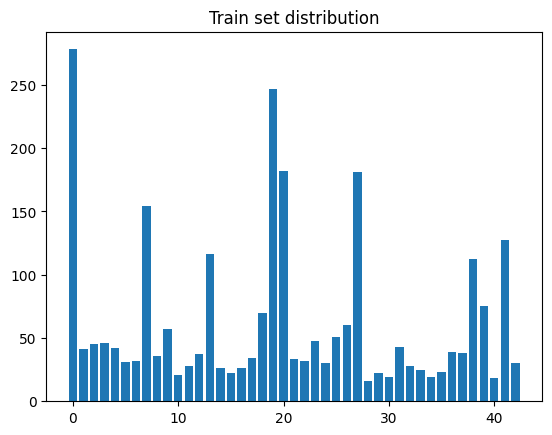

In [ ]:
train_data = GroceryStoreDataset(split="train")
unique_train_classes, per_train_class_count = np.unique(train_data.labels, return_counts=True)
plt.title("Train set distribution")
plt.bar(unique_train_classes, per_train_class_count)
plt.show()

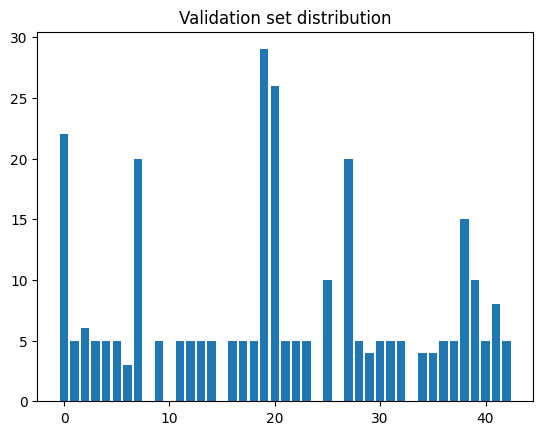

In [ ]:
val_data = GroceryStoreDataset(split="val")
unique_val_classes, per_val_class_count = np.unique(val_data.labels, return_counts=True)
plt.title("Validation set distribution")
plt.bar(unique_val_classes, per_val_class_count)
plt.show()

##Data Loading and preprocessing

In [ ]:
print(f'The number of classes is = {train_data.get_num_classes()}')
NUM_CLASSES = train_data.get_num_classes()

The number of classes is = 43


In [ ]:
INPUT_WIDTH = 256
INPUT_HEIGHT = 256

tsfms = T.Compose([
    T.Resize((INPUT_HEIGHT, INPUT_WIDTH)),
    T.ToTensor(),
])

train_dset = GroceryStoreDataset(split="train", transform=tsfms)
test_dset = GroceryStoreDataset(split="test", transform=tsfms)
val_dset = GroceryStoreDataset(split="val", transform=tsfms)

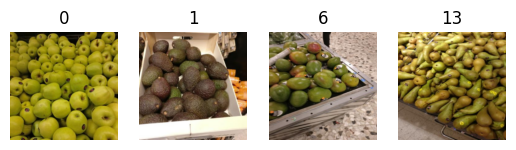

In [ ]:
_, ax = plt.subplots(1, 4)

for i, idx in enumerate([0, 300, 500, 900]):
    img, label = test_dset[idx]
    ax[i].imshow(img.reshape(3, 256, 256).permute(1, 2, 0))
    ax[i].set_title(label)
    ax[i].axis("off")

In [ ]:
print(f'Train dataset has {len(train_dset)} elements')
print(f'Validation dataset has {len(val_dset)} elements')
print(f'Test dataset has {len(test_dset)} elements')

Train dataset has 2640 elements
Validation dataset has 296 elements
Test dataset has 2485 elements


###Augmentation

In [ ]:
augmentation_transforms = [T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomVerticalFlip(p=0.2),
    T.RandomRotation(10),
    T.RandomResizedCrop((INPUT_HEIGHT, INPUT_WIDTH), scale=(0.8, 1.0)),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.RandomGrayscale(p=0.1),
    T.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])]


augmented_train_dset = GroceryStoreDataset(split="train", transform=augmentation_transforms)
train_dset = ConcatDataset([train_dset, augmented_train_dset])
print(f'Train dataset size after augmentation: {len(train_dset)}')
torch.save(train_dset, 'train_dset.pt')


Train dataset size after augmentation: 5280


###Rebalancing

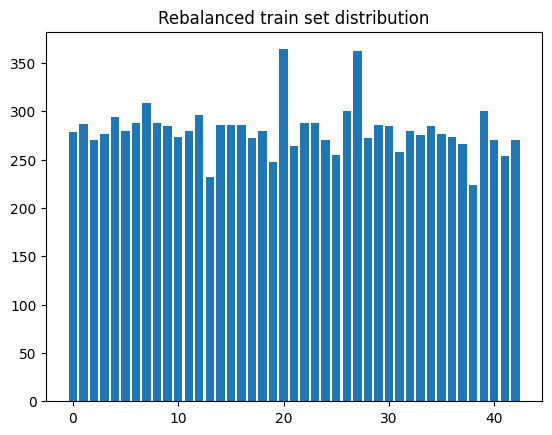

In [ ]:
class GroceryStoreDatasetFilteredByLabel(GroceryStoreDataset):
    def __init__(self, split: str, transform=None, label=None) -> None:
        super().__init__(split, transform)

        # Keep only the images with the specified label
        self.paths = [p for i, p in enumerate(self.paths) if self.labels[i] == label]
        self.labels = [label] * len(self.paths)

def balanceDataset(split):
    # Initial dataset
    balanced_dset = GroceryStoreDataset(split=split, transform=tsfms)

    # Count the number of samples in each class
    balanced_count = [balanced_dset.labels.count(i) for i in range(NUM_CLASSES)]
    biggest_class_size = np.max(balanced_count)

    # List to hold all datasets
    datasets = [balanced_dset]

    for i in range(NUM_CLASSES):
        size_label_i = balanced_count[i]

        # Calculate the factor by which we need to augment the dataset for this label
        increase_factor = round(biggest_class_size / size_label_i)

        for j in range(increase_factor - 1):  # -1 because the original dataset is already included
            augmented_i = GroceryStoreDatasetFilteredByLabel(
                split=split,
                transform=augmentation_transforms[j % len(augmentation_transforms)],  # Cycle through available augmentations
                label=i
            )
            datasets.append(augmented_i)  # Add augmented dataset to the list
            balanced_count[i] += len(augmented_i)  # Update the count for the current label

    # Concatenate all datasets
    balanced_dset = ConcatDataset(datasets)

    return balanced_dset, balanced_count


train_dset, balanced_count = balanceDataset("train")
plt.title("Rebalanced train set distribution")
plt.bar(range(NUM_CLASSES), balanced_count)
plt.show()

In [ ]:
print(f'Train dataset size after rebalancing: {len(train_dset)}')

Train dataset size after rebalancing: 12056


##Utility function

###Train loop

In [44]:
class Trainer:
    def __init__(self,
            model: nn.Module,
            train_loader: DataLoader,
            val_loader: DataLoader,
            device: torch.device,
            num_classes: int
        ) -> None:
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_classes = num_classes
        self.num_epochs = cfg["num_epochs"]

        self.model = model.to(device)
        self.optimizer = AdamW(self.model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
        num_steps = self.num_epochs * len(train_loader)
        self.scheduler = OneCycleLR(self.optimizer, cfg["lr"], total_steps=num_steps)

        self.step = 0
        self.best_acc = 0.0
        self.best_model_path = "best_model.pth"

    def train(self, verbose=False):
        best_val_acc = 0
        best_params = []
        best_epoch = -1
        for e in tqdm(range(self.num_epochs), desc="Epoch"):
            self.model.train() # modalità train

            for imgs, labels in self.train_loader:
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)

                pred = self.model(imgs)
                loss = F.cross_entropy(pred, labels)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.scheduler.step() # Aggiorna lo scheduler del learning rate.

                self.step += 1

            train_loss, train_acc = self.evaluate(self.train_loader)
            val_loss, val_acc = self.evaluate(self.val_loader)

            if verbose:
                print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {train_acc:.3f}" + ("" if self.val_loader is None else f" - valid loss {val_loss:.3f} - valid acc {val_acc:.3f}"))

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = copy.deepcopy(self.model.state_dict())
                best_epoch = e
                torch.save(best_params, self.best_model_path)

        return best_val_acc, best_params, best_epoch

    @torch.no_grad()
    def evaluate(self, data_loader: DataLoader) -> Tuple[float, float]:
        self.model.eval()

        acc = Accuracy("multiclass", num_classes=self.num_classes).to(self.device)

        losses = []
        for imgs, labels in data_loader:
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)

            pred = self.model(imgs)
            loss = F.cross_entropy(pred, labels)
            losses.append(loss.item())

            pred_softmax = F.softmax(pred, dim=-1)
            acc(pred_softmax, labels)

        loss = sum(losses) / len(losses)
        accuracy = acc.compute()

        return loss, accuracy


###Evaluate_model
This function will compute the confusion matrix, calculate accuracy, and plot the confusion matrix as a heatmap.

In [46]:
def evaluate_model(model, test_dl, device, n_classes):

    # Set model to evaluation mode
    model.eval()

    # Initialize confusion matrix
    confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int)

    # Evaluate model without gradient calculation
    with torch.no_grad():
        for test_data in test_dl:
            imgs, labels = test_data
            imgs = imgs.to(device)
            labels = labels.to(device)

            # Forward pass
            scores = model(imgs)
            preds = torch.argmax(scores, -1)

            # Update confusion matrix
            for lbl, pred in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[lbl.int(), pred.int()] += 1

    # Calculate accuracy
    test_acc = (torch.diagonal(confusion_matrix).sum() / confusion_matrix.sum()).item()

    # Print accuracy
    print(f"Test Accuracy: {test_acc:.4f}")

    # Plot confusion matrix
    plt.figure(figsize=(15, 10))
    conf_mtrx_df = pd.DataFrame(confusion_matrix.numpy(),
                                index=[f'Class {i}' for i in range(n_classes)],
                                columns=[f'Class {i}' for i in range(n_classes)])
    sn.heatmap(conf_mtrx_df, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    return test_acc


#Create the Network

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, kernel_size, in_channels, out_channels, activation_fn, use_batch_norm=True, use_skip=True):
        super(ConvBlock, self).__init__()

        # Memorizza i parametri
        self.use_skip = use_skip
        self.activation = activation_fn()

        # Componente del blocco di convoluzione
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=2, padding='valid'),
            nn.BatchNorm2d(out_channels) if use_batch_norm else nn.Identity(),
            self.activation,
            nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding='same'),
            nn.BatchNorm2d(out_channels) if use_batch_norm else nn.Identity()
        ]

        # Creazione del blocco di convoluzione come sequenza di layer
        self.conv_block = nn.Sequential(*layers)

        # Opzionale: blocco di skip connection
        if use_skip:
            self.skip_connection = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding='valid')
        else:
            self.skip_connection = None

    def forward(self, x):
        # Passa attraverso il blocco di convoluzione
        x_out = self.conv_block(x)

        # Gestisce la connessione di skip, se presente
        if self.skip_connection is not None:
            # Calcola la connessione di skip e la adatta alla dimensione dell'output
            x_skip = self.skip_connection(x)
            # Assicura che la dimensione del skip connection sia compatibile
            if x_out.shape != x_skip.shape:
                x_skip = F.interpolate(x_skip, size=x_out.shape[2:], mode='bilinear', align_corners=False)
            x_out += x_skip

        return self.activation(x_out)


In [ ]:
class GroceryModelModular(nn.Module):
    def __init__(self, stem_block, conv_block, linear_block):
        super().__init__()
        self.stem_block = nn.Sequential(*stem_block)
        self.conv_block = nn.Sequential(*conv_block)
        self.linear_block = nn.Sequential(*linear_block)

    def forward(self, x):
        x = self.stem_block(x)
        x = self.conv_block(x)
        # Before flattening the tensor, to further reduce the parameters
        # we use adaptive average pooling
        x = F.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.linear_block(x)
        return x

In [ ]:
class GroceryModelFull(GroceryModelModular):
    def __init__(self, n_classes):
        super(GroceryModelFull, self).__init__(
            stem_block = [
                nn.Conv2d(in_channels=3, out_channels=24, kernel_size=5, stride=2, padding='valid'),
                nn.BatchNorm2d(24),
                nn.ReLU(inplace=True),
                nn.Conv2d(in_channels=24, out_channels=32, kernel_size=5, stride=2, padding='valid'),
                nn.BatchNorm2d(32),
                nn.ReLU(inplace=True)
            ],
            conv_block = [
                ConvBlock(kernel_size=3, in_channels=32, out_channels=48, activation_fn=nn.ReLU),
                ConvBlock(kernel_size=3, in_channels=48, out_channels=72, activation_fn=nn.ReLU)
            ],
            linear_block = [
                nn.Linear(72, 256),
                nn.BatchNorm1d(256),
                nn.ReLU(inplace=True),
                nn.Dropout(p=0.5),
                nn.Linear(256, n_classes)
            ]
        )

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_uniform_(m.weight, a=0.1)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, a=0.1)
                nn.init.zeros_(m.bias)


In [ ]:
model = GroceryModelFull(NUM_CLASSES).to(device)
summary(model, (3 , INPUT_HEIGHT, INPUT_WIDTH), device=device)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 24, 126, 126]           1,824
       BatchNorm2d-2         [-1, 24, 126, 126]              48
              ReLU-3         [-1, 24, 126, 126]               0
            Conv2d-4           [-1, 32, 61, 61]          19,232
       BatchNorm2d-5           [-1, 32, 61, 61]              64
              ReLU-6           [-1, 32, 61, 61]               0
            Conv2d-7           [-1, 48, 30, 30]          13,872
       BatchNorm2d-8           [-1, 48, 30, 30]              96
              ReLU-9           [-1, 48, 30, 30]               0
             ReLU-10           [-1, 48, 30, 30]               0
           Conv2d-11           [-1, 48, 30, 30]          20,784
      BatchNorm2d-12           [-1, 48, 30, 30]              96
           Conv2d-13           [-1, 48, 30, 30]          13,872
             ReLU-14           [-1, 48

In [50]:
cfg = {
    "batch_size": 32,
    "num_epochs": 10,

    "lr": 1e-3,
    "wd": 1e-4,
    "step_size": 5
}

In [51]:
batch_size = 4
train_dl = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dset, batch_size=batch_size)

In [ ]:
trainer = Trainer(
    model,
    train_dl,
    val_dl,
    device,
    NUM_CLASSES
)

trainer.train()

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

###Trainer

In [ ]:
def train(
    model,
    loss_fn,
    optimizer,
    scheduler,
    train_dl,
    val_dl,
    device,
    n_epochs,
    early_stop_val_acc=0.6,
    checkpoint_path=None,
    logging_path=None
):
    # Convert paths to Path objects
    checkpoint_dir = Path(checkpoint_path) if checkpoint_path is not None else None
    logging_dir = Path(logging_path) if logging_path is not None else None

    # Create directories if needed
    if checkpoint_dir is not None:
        checkpoint_dir.mkdir(parents=True, exist_ok=True)
    if logging_dir is not None:
        logging_dir.mkdir(parents=True, exist_ok=True)

    history = []
    model = model.to(device)
    loss_fn = loss_fn.to(device)

    for epoch in (pbar := tqdm(range(n_epochs))):
        batch_train_accuracies = []
        batch_train_losses = []
        batch_train_times = []
        val_accuracy = 0
        val_loss = 0
        curr_lr = scheduler.get_last_lr()[-1] if scheduler is not None else optimizer.param_groups[-1]['lr']

        # Train
        model.train()
        for i, (images, labels) in enumerate(train_dl):
            pbar.set_description(f"Epoch {epoch+1} ({i+1}/{len(train_dl)}) [lr: {curr_lr:.3e}]")
            if device == "cuda":
                start_time = torch.cuda.Event(enable_timing=True)
                end_time = torch.cuda.Event(enable_timing=True)
            images, labels = images.to(device), labels.to(device)

            if device == "cuda": start_time.record()
            optimizer.zero_grad()
            pred_logits = model(images)
            loss = loss_fn(pred_logits, labels)
            loss.backward()
            optimizer.step()
            if device == "cuda": end_time.record()

            _, preds = torch.max(pred_logits, 1)
            batch_train_accuracies.append((preds == labels).sum().item() / labels.size(0))
            batch_train_losses.append(loss.item())
            if device == "cuda":
                torch.cuda.synchronize()
                batch_train_times.append(start_time.elapsed_time(end_time))
        if scheduler is not None:
            scheduler.step()

        # Validation
        model.eval()
        val_accuracy_per_label_count = np.zeros((NUM_CLASSES, 2))
        with torch.no_grad():
            for images, labels in val_dl:
                images, labels = images.to(device), labels.to(device)
                preds_logits = model(images)
                _, pred = torch.max(preds_logits, 1)
                val_accuracy += (pred == labels).sum().item()
                for class_idx in range(NUM_CLASSES):
                    val_accuracy_per_label_count[class_idx, 0] += np.logical_and((pred == labels).cpu().numpy(), (labels == class_idx).cpu().numpy()).sum()
                    val_accuracy_per_label_count[class_idx, 1] += (labels == class_idx).sum().item()

                val_loss += loss_fn(preds_logits, labels).item() * labels.shape[0]

        val_accuracy = val_accuracy / len(val_dl.dataset)
        val_accuracy_per_label_count[val_accuracy_per_label_count[:, 1] == 0, 1] = np.inf
        val_accuracy_per_label = val_accuracy_per_label_count[:, 0] / val_accuracy_per_label_count[:, 1]
        val_loss = val_loss / len(val_dl.dataset)

        print(
            f"Epoch {epoch + 1:<3} [lr: {curr_lr:.3e}] | "
            f"train_acc: {np.mean(batch_train_accuracies):.4f} "
            f"train_loss: {np.mean(batch_train_losses):.4f} "
            f"val_acc: {val_accuracy:.4f} "
            f"val_loss: {val_loss:.4f}",
        )

        # Checkpoint
        if checkpoint_dir is not None:
            checkpoint_file = checkpoint_dir / f"epoch{epoch+1}.ckp.pt"
            torch.save({
                "state_dict": model.state_dict(),
                "architecture": str(model)
            }, checkpoint_file)

        # Logging
        epoch_logs = {
            "epoch": epoch + 1,
            "batch_train_accuracies": batch_train_accuracies,
            "batch_train_losses": batch_train_losses,
            "batch_train_times": batch_train_times,
            "val_accuracy": val_accuracy,
            "val_loss": val_loss,
            "val_accuracy_per_label": val_accuracy_per_label.tolist()
        }
        if logging_dir is not None:
            log_file = logging_dir / f"epoch{epoch+1}.log.json"
            with open(log_file, "w") as f:
                json.dump(epoch_logs, f, indent=3)
        history.append(epoch_logs)

        if (early_stop_val_acc is not None) and (val_accuracy >= early_stop_val_acc):
            break

    return history


###Training

In [ ]:
batch_size = 32
train_dl = DataLoader(train_dset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dset, batch_size=batch_size)

# Model, Loss, Optimizer, and Scheduler
device = "cuda" if torch.cuda.is_available() else "cpu"
model = GroceryModelFull(n_classes=NUM_CLASSES)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.7)

# Train the model
train_history = train(
    model=model,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dl=train_dl,
    val_dl=val_dl,
    device=device,
    n_epochs=20,
    early_stop_val_acc=0.8,
    checkpoint_path="./checkpoints",
    logging_path="./logs"
)

  0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

#Linear NN

### Start with a simple Linear NN

In [ ]:
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes, n_hidden_layers=0):
        super().__init__()

        # Initialize the modules we need to build the network
        self.first = nn.Linear(input_dim, hidden_dim)
        self.activation = nn.ReLU()
        self.last = nn.Linear(hidden_dim, n_classes)

        self.hidden_layers = nn.ModuleList([
            nn.Linear(hidden_dim, hidden_dim) for i in range(n_hidden_layers)
        ])

    def forward(self, x):
        # Perform the calculation of the model to determine the prediction
        x = self.first(x)
        x = self.activation(x)
        for layer in self.hidden_layers:
            x = layer(x)
            x = self.activation(x)
        x = self.last(x)

        return x

In [ ]:
hidden_dim = 128
n_classes = train_dset.get_num_classes()
input_dim = len(train_dset[0][0])

model = SimpleClassifier(
    input_dim,
    hidden_dim,
    n_classes,
    n_hidden_layers=1
)

for name, params in model.named_parameters():
    print(f"{name}: {params.shape}")

AttributeError: 'ConcatDataset' object has no attribute 'get_num_classes'

In [ ]:
model.to(device)

### Optimization

In [ ]:
optimizer = Adam(model.parameters(), lr=0.001)

In [ ]:
def ncorrect(scores, y): # scores sono le prediction, y sono le labels
    y_hat = torch.argmax(scores, -1) # prendo l'indice massimo di ogni score per tutti i dati del batch
    return (y_hat == y).sum() # faccio la somma per avere il numero di prediction corrette per batch

def accuracy(scores, y): # questo è solo per il calcolo della percentuale, quindi accuracy
    correct = ncorrect(scores, y)
    return correct.true_divide(y.shape[0])

def train_loop(model, train_dl, epochs, opt, val_dl=None, verbose=False):
    best_val_acc = 0
    best_params = []
    best_epoch = -1

    for e in tqdm(range(epochs)):
        # tqdm è una libreria Python utilizzata per mostrare barre di progresso nei cicli. È particolarmente utile quando si eseguono
        # operazioni che richiedono molto tempo

        model.train() #  il modello viene impostato in modalità di addestramento
        # ha i seguenti effetti: Impostare il modello in modalità di addestramento è cruciale perché alcuni moduli si comportano
        #                        diversamente durante l'addestramento e la valutazione.
        #                        Inoltre attiva il dropout e la BatchNormalization se sono presenti

        # Train #############################################################
        train_loss = 0
        train_samples = 0
        train_acc = 0
        for train_data in train_dl: # Tramite il dataloader prendo un batch, (img, label)

            # Questo codice serve a trasferire i dati di addestramento(tensore) (immagini e etichette) sul dispositivo specificato
            # (tipicamente una GPU) per accelerare l'addestramento del modello.
            imgs = train_data[0].to(device)
            labels = train_data[1].to(device)

            # forward pass del modello di deep learning model su un batch di immagini imgs e memorizza i risultati in scores
            scores = model(imgs) # tensore di 43 output

            loss = F.cross_entropy(scores, labels) # RICORDO che è la media !! Per questo si fa poi * imgs.shape[0]

            train_loss += loss.item() * imgs.shape[0] # loss è un tensore, e loss.item() estrae il valore numerico dallo stesso.
            # Questo valore rappresenta la perdita media per il batch corrente.

            train_samples += imgs.shape[0] # perchè la prima dimensione tiene conto del numero di samples usati
            train_acc += ncorrect(scores, labels).item()

            opt.zero_grad()  # Questa linea resetta (azzera) tutti i gradienti dei tensori ottimizzati dal modello. In PyTorch, i gradienti degli ottimizzatori vengono accumulati (cioè sommati) per default.
            loss.backward()  # Questa linea calcola i gradienti della funzione di perdita rispetto a tutti i parametri del modello (cioè esegue la backpropagation).
            opt.step()       # esegue un passo dell'ottimizzatore, cioè aggiorna i pesi del modello usando i gradienti calcolati nella fase precedente.

        # percentuale accuracy e percentuale loss
        train_acc /= train_samples
        train_loss /= train_samples

        # Validation #################################################################################à
        model.eval() # imposta il modello in modalità di valutazione.
        # Il modello viene utilizzato per fare previsioni sui dati di test o di validazione.
        # Le tecniche come il dropout vengono disattivate in questa fase perché non vogliamo introdurre casualità nelle previsioni.

        with torch.no_grad():
        # with torch.no_grad():: Questo contesto temporaneamente disabilita il calcolo dei gradienti.
        # È utile durante la valutazione del modello per evitare di accumulare gradienti e risparmiare memoria.

            val_loss = 0
            val_samples = 0
            val_acc = 0
            if val_dl is not None: # quindi solo se è predente un dataset per la validazione
                for val_data in val_dl: # prendo i batch di validation

                    # li metto sulla GPU
                    imgs = val_data[0].to(device)
                    labels = val_data[1].to(device)

                    # forward pass
                    val_scores = model(imgs)

                    val_loss += F.cross_entropy(val_scores, labels).item() * imgs.shape[0]
                    val_samples += imgs.shape[0]
                    val_acc += ncorrect(val_scores, labels).item()
                val_acc /= val_samples
                val_loss /= val_samples

            if val_dl is None or val_acc > best_val_acc:
                best_val_acc = val_acc if val_dl is not None else 0

                # Questo metodo restituisce un dizionario contenente i parametri (pesi e bias) di tutti gli strati del modello.
                # Le chiavi del dizionario sono i nomi dei parametri e i valori sono i tensori dei parametri stessi.
                best_params = model.state_dict()

                torch.save(best_params, "best_model.pth") # vengono salvati in un file chiamato "best_model.pth. Probabilmente vengono salvati nella root directory
                best_epoch = e

        # verbose: Questo è un parametro che controlla se le informazioni dettagliate dovrebbero essere stampate o meno.
        # Se è True, allora le informazioni vengono stampate.
        # e % 5 == 0: Questa condizione controlla se l'epoca corrente (e) è un multiplo di 5. In altre parole, stampa le informazioni solo ogni 5 epoche.
        if verbose and e % 5 == 0:
            print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {train_acc:.3f}" + ("" if val_dl is None else f" - valid loss {val_loss:.3f} - valid acc {val_acc:.3f}"))

    if verbose and val_dl is not None:
        print(f"Best epoch {best_epoch}, best acc {best_val_acc}")

    return best_val_acc, best_params, best_epoch

### Training del primo modello semplice

In [ ]:
epochs = 20

best_val_acc, best_params, best_epoch = train_loop(
    model,
    train_dl,
    epochs,
    optimizer,
    val_dl,
    verbose=True
)

In [ ]:
# il file best_model.pth è memorizzato nel filesystem temporaneo associato alla tua sessione di Colab
# significa che dovrò sempre poi rerunnare il modello -> non mi piace
# adesso trovo un modo per salvarlo per sempre in modo tale da non dover più rerunnare tutto il training

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp best_model.pth /content/drive/MyDrive/assignment

In [ ]:
torch.argmax(model(test_dset[0][0]), -1).item()

In [ ]:
model(test_dset[0][0])

#### Uso di una confusion matrix per verificare il modello come si comporta nella prediction delle classi

In [ ]:
model.eval()
confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int)

with torch.no_grad():
    for test_data in test_dl:
        imgs, labels = test_data
        imgs = imgs.to(device)
        labels = labels.to(device)

        scores = model(imgs) # tensore risultate dalla prediction
        preds = torch.argmax(scores, -1) # prendo solo l'indice con il risultato maggiore per tutti i datapoint del batch

        # view(-1) di un tensore in PyTorch è utilizzato per rimodellare (reshape) il tensore in una vista 1D (unidimensionale) mantenendo lo stesso numero di elementi.
        for lbl, pred in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[lbl.int(), pred.int()] += 1 # aggiunge +1 per ogni prediction del batch

# estrae gli elementi diagonali della matrice di confusione. Gli elementi diagonali rappresentano il numero di predizioni corrette
# per ciascuna classe (ovvero, dove l'etichetta reale coincide con la predizione)
# .sum() somma questi elementi, ottenendo il totale delle predizioni corrette.
test_acc = (torch.diagonal(confusion_matrix).sum() / confusion_matrix.sum()).item() # confusion_matrix.sum() calcola la somma di tutti gli elementi nella matrice di confusione
print(test_acc) # non fa altro che un calcolo dell'accuracy sui dati di test

In [ ]:
plt.figure(figsize=(15, 10))
conf_mtrx_df = pd.DataFrame(confusion_matrix)
sn.heatmap(conf_mtrx_df, annot=True, fmt="d");
plt.show()

## Model 2 con aggiunta di più layers con batch normalization
Potrei anche rifare il primo modello con l'aggiunta di questa tecnica, poichè a livello teorico e sperimentale il primo modello fatto è senza senso, quindi si potrebbe partire da una base più solida

In [ ]:
def get_linear_bn_relu(input_dim, out_dim):
    modules = []
    modules.append(nn.Linear(input_dim, out_dim))
    modules.append(nn.BatchNorm1d(out_dim))
    modules.append(nn.ReLU())

    # costruisce un modulo sequenziale da una lista di moduli. *modules è la sintassi per passare la lista di moduli come argomenti
    # separati alla funzione nn.Sequential.
    # Il modulo sequenziale restituito applica ogni modulo nell'ordine in cui sono stati aggiunti alla lista quando viene chiamato
    # con un input.
    return nn.Sequential(*modules)

class SimpleClassifierBNv2(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_classes, n_hidden_layers=0):
        super().__init__()

        self.first = get_linear_bn_relu(input_dim, hidden_dim)
        self.last = nn.Linear(hidden_dim, n_classes)

        self.hidden_layers = nn.ModuleList([
            get_linear_bn_relu(hidden_dim, hidden_dim) for i in range(n_hidden_layers)
        ])

    def forward(self, x):
        x = self.first(x)
        for layer in self.hidden_layers:
            x = layer(x)
        x = self.last(x)
        return x

In [ ]:
model2 = SimpleClassifierBNv2(
    input_dim,
    hidden_dim,
    n_classes,
    n_hidden_layers=3
)

model2.to(device)

optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)
epochs = 25

best_val_acc, best_params, best_epoch = train_loop(
    model2,
    train_dl,
    epochs,
    optimizer,
    val_dl,
    verbose=True)

Non è cambiato nulla a livello di accuracy

In [ ]:
!cp best_model.pth /content/drive/MyDrive/assignment

In [ ]:
for name, params in model2.named_parameters():
    print(f"{name}: {params.shape}")

In [ ]:
# Il Batch Normalization (BatchNorm) aggiunge un tensore di pesi e uno di bias per consentire alla rete neurale di apprendere i
# parametri di scala e traslazione appropriati durante l'addestramento.
# Il Batch Normalization (BatchNorm) aggiunge un tensore di pesi e uno di bias per consentire alla rete neurale di apprendere i parametri
# di scala e traslazione appropriati durante l'addestramento.
# Questi parametri vengono appresi durante l'addestramento

Load the model 2

In [ ]:
state_dict = torch.load("/content/drive/MyDrive/assignment/modulo2/model_2.pth")

hidden_dim = 128
n_classes = train_dset.get_num_classes()
input_dim = len(train_dset[0][0])

model_2 = model = SimpleClassifierBNv2(
    input_dim,
    hidden_dim,
    n_classes,
    n_hidden_layers=3
)

model_2.load_state_dict(state_dict)

model_2.to(device)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Testing model 2 and Confusion Matrix

In [ ]:
model_2.eval()
confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int)

with torch.no_grad():
    for test_data in test_dl:
        imgs, labels = test_data
        imgs = imgs.to(device)
        labels = labels.to(device)

        scores = model_2(imgs)
        preds = torch.argmax(scores, -1)

        for lbl, pred in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[lbl.int(), pred.int()] += 1

test_acc = (torch.diagonal(confusion_matrix).sum() / confusion_matrix.sum()).item()
print(test_acc)

In [ ]:
plt.figure(figsize=(15, 10))
conf_mtrx_df = pd.DataFrame(confusion_matrix)
sn.heatmap(conf_mtrx_df, annot=True, fmt="d");
plt.show()

#CNN_1

In [ ]:
cfg = {
    "batch_size": 4,
}

In [ ]:
train_dl = DataLoader(
    train_dset,
    batch_size=cfg['batch_size'],
    shuffle=True,
    pin_memory=True
)
val_dl = DataLoader(
    val_dset,
    batch_size=cfg['batch_size'],
    shuffle=False
)
test_dl = DataLoader(
    test_dset,
    batch_size=cfg['batch_size']
)

In [ ]:
image, label = train_dset[0]
print(image.shape)

torch.Size([3, 256, 256])


In [ ]:
def get_conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()

        self.conv1 = get_conv_bn_relu(3, 32)
        self.conv2 = get_conv_bn_relu(32, 64)
        self.conv3 = get_conv_bn_relu(64, 128)
        self.conv4 = get_conv_bn_relu(128, 256)

        self.pool = nn.MaxPool2d(2, 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))
        x = self.conv4(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN_model = CNNClassifier(n_classes).to(device)

summary(CNN_model, input_size=(3, 256, 256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
         MaxPool2d-4         [-1, 32, 128, 128]               0
            Conv2d-5         [-1, 64, 128, 128]          18,496
       BatchNorm2d-6         [-1, 64, 128, 128]             128
              ReLU-7         [-1, 64, 128, 128]               0
         MaxPool2d-8           [-1, 64, 64, 64]               0
            Conv2d-9          [-1, 128, 64, 64]          73,856
      BatchNorm2d-10          [-1, 128, 64, 64]             256
             ReLU-11          [-1, 128, 64, 64]               0
        MaxPool2d-12          [-1, 128, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         295,168
      BatchNorm2d-14          [-1, 256,

In [ ]:
CNN_model.to(device)

optimizer = torch.optim.Adam(CNN_model.parameters(), lr=0.01)
epochs = 20

best_val_acc, best_params, best_epoch = train_loop(
    CNN_model,
    train_dl,
    epochs,
    optimizer,
    val_dl,
    verbose=True)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 0: train loss 2.972 - train acc 0.199 - valid loss 2.889 - valid acc 0.223
Epoch 5: train loss 1.496 - train acc 0.530 - valid loss 2.894 - valid acc 0.321
Epoch 10: train loss 0.890 - train acc 0.712 - valid loss 2.167 - valid acc 0.503
Epoch 15: train loss 0.570 - train acc 0.820 - valid loss 2.677 - valid acc 0.497
Best epoch 14, best acc 0.5304054054054054


In [ ]:
!cp best_model.pth /content/drive/MyDrive/assignment

In [ ]:
CNN_model.eval()
confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int)

with torch.no_grad():
    for test_data in test_dl:
        imgs, labels = test_data
        imgs = imgs.to(device)
        labels = labels.to(device)

        scores = CNN_model(imgs)
        preds = torch.argmax(scores, -1)

        for lbl, pred in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[lbl.int(), pred.int()] += 1

test_acc = (torch.diagonal(confusion_matrix).sum() / confusion_matrix.sum()).item()
print(test_acc)

0.5975854992866516


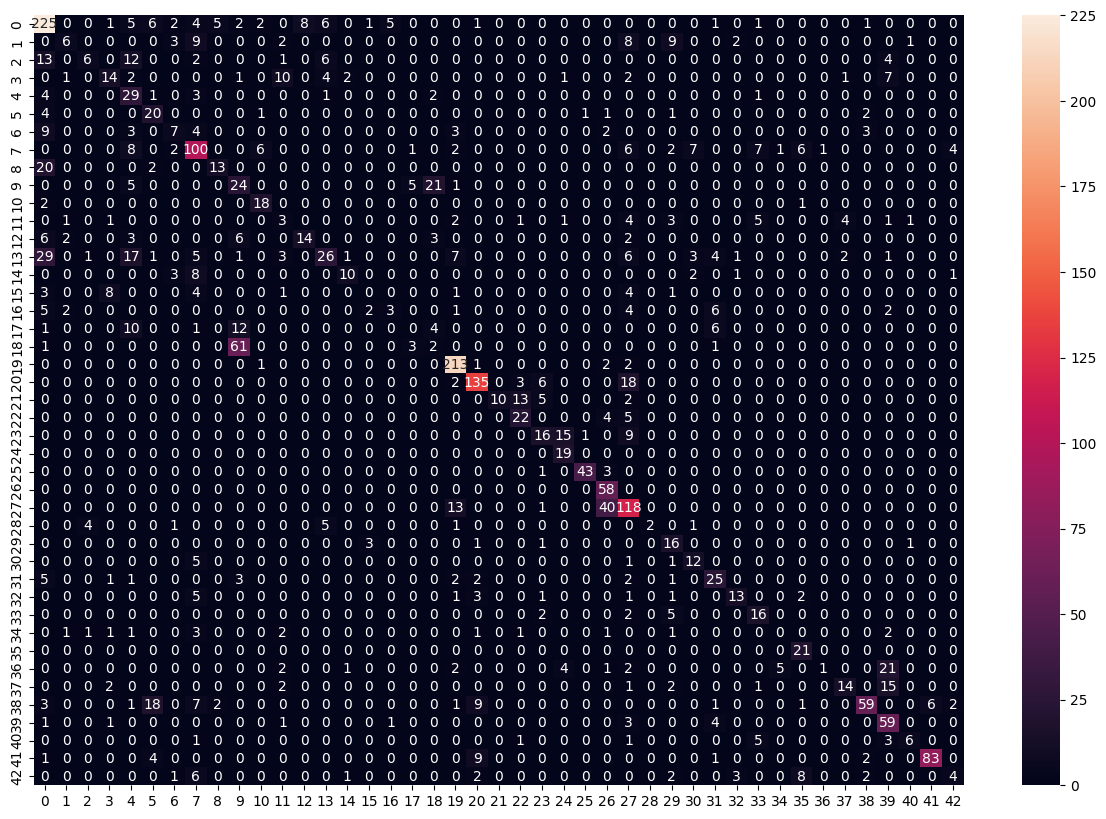

In [ ]:
plt.figure(figsize=(15, 10))
conf_mtrx_df = pd.DataFrame(confusion_matrix)
sn.heatmap(conf_mtrx_df, annot=True, fmt="d");
plt.show()

Ho raggiunto una precisione dui dati di test di circa 60 per cento
Provo a migliorare il modello ulteriormente

# CNN_2
In questo caso provo a normalizzare i dati e a usare tecniche per la regolarizzazione per l'addestramento

In [ ]:
cfg = {
    "resize_size": 256,
    "crop_size": 224,

    "batch_size": 4,
    "num_epochs": 20,

    "lr": 1e-3,
    "wd": 1e-4,
    "step_size": 5
}

In [ ]:
train_dset = GroceryStoreDataset('train', transform=T.Compose([T.Resize((256, 256)), T.ToTensor()]))
images = []
for image, _ in train_dset:
    images.append(np.array(image))

# Calcola le medie e le deviazioni standard delle immagini
mean_training_data = np.mean(images, axis=(0, 2, 3))
std_training_data = np.std(images, axis=(0, 2, 3))


In [ ]:
print(mean_training_data)
print(std_training_data)

[0.53058594 0.3963665  0.2563837 ]
[0.24343865 0.22089787 0.20542131]


In [ ]:
data_transforms = {
    "train": T.Compose([T.RandomResizedCrop(cfg["crop_size"]),
                        T.RandomHorizontalFlip(),
                        T.ToTensor(),
                        T.Normalize(mean_training_data, std_training_data)]),

    "val": T.Compose([T.CenterCrop(cfg["crop_size"]),
                      T.ToTensor(),
                      T.Normalize(mean_training_data, std_training_data)]),

    "test": T.Compose([T.Resize((cfg["crop_size"], cfg["crop_size"])),
                       T.ToTensor()])
}

train_dset = GroceryStoreDataset('train', transform=data_transforms['train'])
val_dset = GroceryStoreDataset('val', transform=data_transforms['val'])
test_dset = GroceryStoreDataset('test', transform=data_transforms['test'])

In [ ]:
train_dl = DataLoader(
    train_dset,
    batch_size=cfg['batch_size'],
    shuffle=True,
    pin_memory=True
)
val_dl = DataLoader(
    val_dset,
    batch_size=cfg['batch_size'],
    shuffle=False
)
test_dl = DataLoader(
    test_dset,
    batch_size=cfg['batch_size']
)

In [ ]:
n_classes = train_dset.get_num_classes()
image, label = train_dset[0]
print(image.shape)

torch.Size([3, 224, 224])


In [ ]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 41.0 MB/s eta 0:00:00


In [ ]:
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torchmetrics.classification.accuracy import Accuracy
import copy

In [ ]:
import copy

class Trainer:
    def __init__(self,
            model: nn.Module,
            train_loader: DataLoader,
            val_loader: DataLoader,
            device: torch.device,
            num_classes: int
        ) -> None:
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_classes = num_classes
        self.num_epochs = cfg["num_epochs"]

        self.model = model.to(device)
        self.optimizer = AdamW(self.model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
        num_steps = self.num_epochs * len(train_loader)
        self.scheduler = OneCycleLR(self.optimizer, cfg["lr"], total_steps=num_steps)

        self.step = 0
        self.best_acc = 0.0
        self.best_model_path = "best_model.pth"

    def train(self, verbose=False):
        best_val_acc = 0
        best_params = []
        best_epoch = -1
        for e in tqdm(range(self.num_epochs), desc="Epoch"):
            self.model.train() # modalità train

            for imgs, labels in self.train_loader:
                imgs = imgs.to(self.device)
                labels = labels.to(self.device)

                pred = self.model(imgs)
                loss = F.cross_entropy(pred, labels)

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                self.scheduler.step() # Aggiorna lo scheduler del learning rate.

                self.step += 1

            train_loss, train_acc = self.evaluate(self.train_loader)
            val_loss, val_acc = self.evaluate(self.val_loader)

            if verbose:
                print(f"Epoch {e}: train loss {train_loss:.3f} - train acc {train_acc:.3f}" + ("" if self.val_loader is None else f" - valid loss {val_loss:.3f} - valid acc {val_acc:.3f}"))

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_params = copy.deepcopy(self.model.state_dict())
                best_epoch = e
                torch.save(best_params, self.best_model_path)

        return best_val_acc, best_params, best_epoch

    @torch.no_grad()
    def evaluate(self, data_loader: DataLoader) -> Tuple[float, float]:
        self.model.eval()

        acc = Accuracy("multiclass", num_classes=self.num_classes).to(self.device)

        losses = []
        for imgs, labels in data_loader:
            imgs = imgs.to(self.device)
            labels = labels.to(self.device)

            pred = self.model(imgs)
            loss = F.cross_entropy(pred, labels)
            losses.append(loss.item())

            pred_softmax = F.softmax(pred, dim=-1)
            acc(pred_softmax, labels)

        loss = sum(losses) / len(losses)
        accuracy = acc.compute()

        return loss, accuracy


In [ ]:
def get_conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU()
    )

In [ ]:
class CNNClassifier(nn.Module):
    def __init__(self, num_classes):
        super(CNNClassifier, self).__init__()

        self.conv1 = get_conv_bn_relu(3, 32)
        self.conv2 = get_conv_bn_relu(32, 64)
        self.conv3 = get_conv_bn_relu(64, 128)
        self.conv4 = get_conv_bn_relu(128, 256)
        self.conv5 = get_conv_bn_relu(256, 512)
        self.conv6 = get_conv_bn_relu(512, 1024)

        self.pool = nn.MaxPool2d(2, 2)
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.dropout = nn.Dropout(0.5)  # Aggiunto dropout

        # Modificato l'ultimo strato lineare
        self.fc = nn.Linear(1024, num_classes)

        # dato che ho solo un layer lineare potrei provare a usarne due
        # self.fc1 = nn.Linear(1024, 256)
        # self.fc2 = nn.Linear(256, num_classes)
        # uso soft max

    def forward(self, x):
        x = self.pool(self.conv1(x))
        x = self.pool(self.conv2(x))
        x = self.pool(self.conv3(x))
        x = self.pool(self.conv4(x))
        x = self.pool(self.conv5(x))
        x = self.conv6(x)
        x = self.avg_pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)  # Applicato dropout
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
CNN_model_2 = CNNClassifier(n_classes).to(device)

summary(
    CNN_model_2,
    input_size=(3, cfg["crop_size"], cfg["crop_size"])
)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
              ReLU-3         [-1, 32, 224, 224]               0
         MaxPool2d-4         [-1, 32, 112, 112]               0
            Conv2d-5         [-1, 64, 112, 112]          18,496
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9          [-1, 128, 56, 56]          73,856
      BatchNorm2d-10          [-1, 128, 56, 56]             256
             ReLU-11          [-1, 128, 56, 56]               0
        MaxPool2d-12          [-1, 128, 28, 28]               0
           Conv2d-13          [-1, 256, 28, 28]         295,168
      BatchNorm2d-14          [-1, 256,

In [ ]:
trainer = Trainer(
    CNN_model_2,
    train_dl,
    val_dl,
    device,
    n_classes
)

trainer.train()

Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
!cp best_model.pth /content/drive/MyDrive/assignment

In [ ]:
CNN_model_2.eval()
confusion_matrix = torch.zeros(n_classes, n_classes, dtype=torch.int)

with torch.no_grad():
    for test_data in test_dl:
        imgs, labels = test_data
        imgs = imgs.to(device)
        labels = labels.to(device)

        scores = CNN_model_2(imgs)
        preds = torch.argmax(scores, -1)

        for lbl, pred in zip(labels.view(-1), preds.view(-1)):
                confusion_matrix[lbl.int(), pred.int()] += 1

test_acc = (torch.diagonal(confusion_matrix).sum() / confusion_matrix.sum()).item()
print(test_acc)

In [ ]:
plt.figure(figsize=(15, 10))
conf_mtrx_df = pd.DataFrame(confusion_matrix)
sn.heatmap(conf_mtrx_df, annot=True, fmt="d");
plt.show()

## Part 2: fine-tune an existing network

Your goal is to fine-tune a pretrained **ResNet-18** model on `GroceryStoreDataset`. Use the implementation provided by PyTorch, do not implement it yourselves! (i.e. exactly what you **could not** do in the first part of the assignment). Specifically, you must use the PyTorch ResNet-18 model pretrained on ImageNet-1K (V1). Divide your fine-tuning into two parts:

1. First, fine-tune the Resnet-18 with the same training hyperparameters you used for your best model in the first part of the assignment.
1. Then, tweak the training hyperparameters in order to increase the accuracy on the validation split of `GroceryStoreDataset`. Justify your choices by analyzing the training plots and/or citing sources that guided you in your decisions (papers, blog posts, YouTube videos, or whatever else you find enlightening). You should consider yourselves satisfied once you obtain a classification accuracy on the **validation** split **between 80 and 90%**.

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

In [ ]:
n_classes = train_dset.get_num_classes()

## Part 1

In [ ]:
class GroceryModelResNet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

        self.freezeAll()
        self.unfreezeLinear()


    def freezeAll(self):
        for p in self.resnet.parameters():
            p.requires_grad = False

    def unfreezeAll(self):
        for p in self.resnet.parameters():
            p.requires_grad = True

    def freezeLinear(self):
        for p in self.resnet.fc.parameters():
            p.requires_grad = False

    def unfreezeLinear(self):
        for p in self.resnet.fc.parameters():
            p.requires_grad = True


    def forward(self, x):
        return self.resnet(x)

In [ ]:
model = GroceryModelResNet(NUM_CLASSES)
print_model_parameters(model)
summary(model, (3, 10, 10), device="cpu")

In [ ]:
NN_1 = resnet18(weights=ResNet18_Weights, num_classes=n_classes).to(device)

summary(
    NN_1,
    input_size=(3, cfg["crop_size"], cfg["crop_size"])
)

In [ ]:
# presumo questi siano i training hyperparameters
cfg = {
    "resize_size": 256,
    "crop_size": 224,

    "batch_size": 4,
    "num_epochs": 20,

    "lr": 1e-3,
    "wd": 1e-4,
    "step_size": 5
}

## Part 2

In [ ]:
fix_random(SEED)

model = GroceryModelResNet(NUM_CLASSES).to(device)
loss = default_args["Loss"](**default_args["loss_args"])
optimizer = default_args["Optimizer"](model.parameters(), **default_args["optimizer_args"])
scheduler = None
if default_args["Scheduler"] is not None:
    scheduler = default_args["Scheduler"](optimizer, **default_args["scheduler_args"])

history_resnet = train(
    model = model,
    loss_fn = loss,
    optimizer = optimizer,
    scheduler = scheduler,
    train_dl = DataLoader(train_dset, default_args["batch_size"], shuffle=True),
    val_dl = DataLoader(val_dset, 256),
    device = device,
    n_epochs = default_args["epochs"],
    early_stop_val_acc = 0.85,
    checkpoint_path = f"./checkpoints_{GroceryModelResNet.__name__}",
    logging_path = f"./logs_{GroceryModelResNet.__name__}"
)


In [ ]:
fix_random(SEED)
model.unfreezeAll()

history_resnet_finetune = train(
    model = model,
    loss_fn = loss,
    optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=0.1),
    scheduler = None,
    train_dl = DataLoader(train_dset, default_args["batch_size"], shuffle=True),
    val_dl = DataLoader(val_dset, 256),
    device = device,
    n_epochs = 100,
    early_stop_val_acc = 0.9,
    checkpoint_path = f"./checkpoints_{GroceryModelResNet.__name__}_finetune",
    logging_path = f"./logs_{GroceryModelResNet.__name__}_finetune"
)